#Implement VAR Model in python
Vector AutoRegressive (VAR) is a multivariate forecasting algorithm that is used when two or more time series influence each other.


Dataset: VAR model using the Money (M2SLMoneyStock.csv) and Spending(PCEPersonalSpending.csv) dataset. We combine these datasets into a single dataset that shows that money and spending influence each other.

Steps that we need to follow to build the VAR model are:

1. Examine the Data
2. Test for stationarity
2.1 If the data is non-stationary, take the difference.
2.2 Repeat this process until you get the stationary data.
3. Train Test Split
4. Grid search for order P
5. Apply the VAR model with order P
6. Forecast on new data.
7. If necessary, invert the earlier transformation.

#1. Examine the data

In [149]:
# import necessary libraries (numpy, pandas, matplotlib)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [150]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [151]:
#Now read the dataset

money_df = pd.read_csv('/content/drive/MyDrive/Hitesh TSA (CSE471) LAB Work/DATASETs/LAB 9/M2SLMoneyStock.csv', parse_dates = ['Date']) #read 'M2SLMoneyStock.csv'
spending_df = pd.read_csv('/content/drive/MyDrive/Hitesh TSA (CSE471) LAB Work/DATASETs/LAB 9/PCEPersonalSpending.csv', parse_dates = ['Date']) #read 'PCEPersonalSpending.csv'
df = money_df.merge(spending_df)
# df.to_csv('var_data.csv')

In [152]:
df

,Date,Money,Spending
0,1995-01-01,3492.4,4851.2
1,1995-02-01,3489.9,4850.8
2,1995-03-01,3491.1,4885.4
3,1995-04-01,3499.2,4890.2
4,1995-05-01,3524.2,4933.1
...,...,...,...
247,2015-08-01,12096.8,12394.0
248,2015-09-01,12153.8,12392.8
249,2015-10-01,12187.7,12416.1
250,2015-11-01,12277.4,12450.1


In [153]:
df = df.set_index('Date')

In [154]:
df.index = pd.to_datetime(df.index)

In [155]:
# preview using head
df.head()

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


# 2.Check for Stationarity

In [156]:
# Check both the features (Money,Spending ) whether they are stationary or not. using ADF test
# perform differencing if non stationary

In [157]:
from statsmodels.tsa.stattools import adfuller

In [158]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [159]:
adf_test(df['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistic        4.239022
p-value                   1.000000
# lags used               4.000000
# observations          247.000000
critical value (1%)      -3.457105
critical value (5%)      -2.873314
critical value (10%)     -2.573044
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [160]:
adf_test(df['Spending'])

Augmented Dickey-Fuller Test: 
ADF test statistic        0.149796
p-value                   0.969301
# lags used               3.000000
# observations          248.000000
critical value (1%)      -3.456996
critical value (5%)      -2.873266
critical value (10%)     -2.573019
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [161]:
df_difference = df.diff()

In [162]:
adf_test(df_difference['Money'])


Augmented Dickey-Fuller Test: 
ADF test statistic       -2.057404
p-value                   0.261984
# lags used              15.000000
# observations          235.000000
critical value (1%)      -3.458487
critical value (5%)      -2.873919
critical value (10%)     -2.573367
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [163]:
adf_test(df_difference['Spending'])


Augmented Dickey-Fuller Test: 
ADF test statistic     -7.226974e+00
p-value                 2.041027e-10
# lags used             2.000000e+00
# observations          2.480000e+02
critical value (1%)    -3.456996e+00
critical value (5%)    -2.873266e+00
critical value (10%)   -2.573019e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [164]:
df_difference['Money'] = df_difference['Money'].diff()

In [165]:
adf_test(df_difference['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.077471e+00
p-value                 4.760675e-10
# lags used             1.400000e+01
# observations          2.350000e+02
critical value (1%)    -3.458487e+00
critical value (5%)    -2.873919e+00
critical value (10%)   -2.573367e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


#3. Train-Test Split

In [166]:
 #use the last 1 year of data as a test set (last 12 months).
 df_difference = df_difference.dropna()

In [167]:
test_obs = 12
train = df_difference[:-test_obs]
test = df_difference[-test_obs:]

# 4. Grid Search for Order P

In [168]:
from statsmodels.tsa.api import VAR


In [169]:
for i in [1,2,3,4,5,6,7,8,9,10]:
    model = VAR(train)
    results = model.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()

Order = 1
AIC:  13.893730044437806
BIC:  13.981529035352619

Order = 2
AIC:  13.788978767127503
BIC:  13.935751301238756

Order = 3
AIC:  13.800828407726483
BIC:  14.00693137452656

Order = 4
AIC:  13.705254945442732
BIC:  13.971048877393326

Order = 5
AIC:  13.702894884622165
BIC:  14.028744008993176

Order = 6
AIC:  13.716410512160271
BIC:  14.102682803812531

Order = 7
AIC:  13.722469221920354
BIC:  14.169536457053054

Order = 8
AIC:  13.72242698338018
BIC:  14.230664794264479

Order = 9
AIC:  13.706168588518498
BIC:  14.275956519239289

Order = 10
AIC:  13.744769881188871
BIC:  14.37649144441732



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

# 5. Fit VAR(5) Model

In [170]:
#fit the model and check the summary
result = model.fit(5)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 12, Oct, 2023
Time:                     05:17:04
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    14.0287
Nobs:                     233.000    HQIC:                   13.8343
Log likelihood:          -2235.61    FPE:                    893620.
AIC:                      13.7029    Det(Omega_mle):         814863.
--------------------------------------------------------------------
Results for equation Money
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              -1.884757         3.499904           -0.539           0.590
L1.Money           -0.643407         0.068285           -9.422           0.000
L1.Spending        -0.087249         0.054567           -1.599      

#6 Predict Test Data

In [171]:
# VAR .forecast() function requires that we pass in a lag order number of previous observations.
lagged_Values = train.values[-8:]
pred = result.forecast(y=lagged_Values, steps=12)

idx = pd.date_range('2015-01-01', periods=12, freq='MS')
df_forecast=pd.DataFrame(data=pred, index=idx, columns=['money2d', 'spending2d'])

# 7. Invert the transformation

In [172]:
#We have to note that the forecasted value is a second-order difference. To get it similar to original data we have to roll back each difference. This can be done by taking the most recent values of the original series’ training data and adding it to a cumulative sun of forecasted values.

In [173]:
df_forecast['Money1d'] = (df['Money'].iloc[-test_obs-1]-df['Money'].iloc[-test_obs-2]) + df_forecast['money2d'].cumsum()
df_forecast['MoneyForecast'] = df['Money'].iloc[-test_obs-1] + df_forecast['Money1d'].cumsum()


In [174]:
df_forecast['Spending1d'] = (df['Spending'].iloc[-test_obs-1]-df['Spending'].iloc[-test_obs-2]) + df_forecast['spending2d'].cumsum()
df_forecast['SpendingForecast'] = df['Spending'].iloc[-test_obs-1] + df_forecast['Spending1d'].cumsum()

# Plot the result

<Axes: xlabel='Date'>

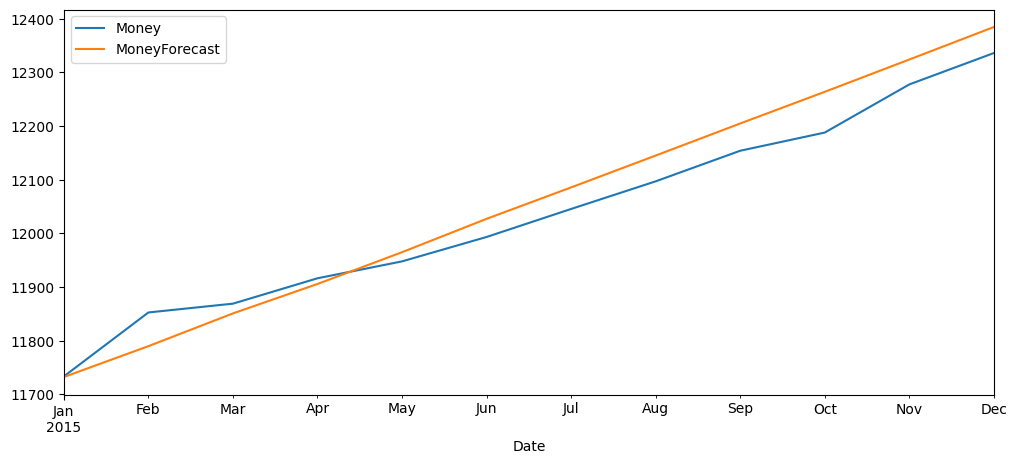

In [175]:
#plot the predicted v/s original values of ‘Money’ and ‘Spending’ for test data.

test_original = df[-test_obs:]
test_original.index = pd.to_datetime(test_original.index)
test_original['Money'].plot(figsize=(12,5),legend=True)
df_forecast['MoneyForecast'].plot(legend=True)

<Axes: xlabel='Date'>

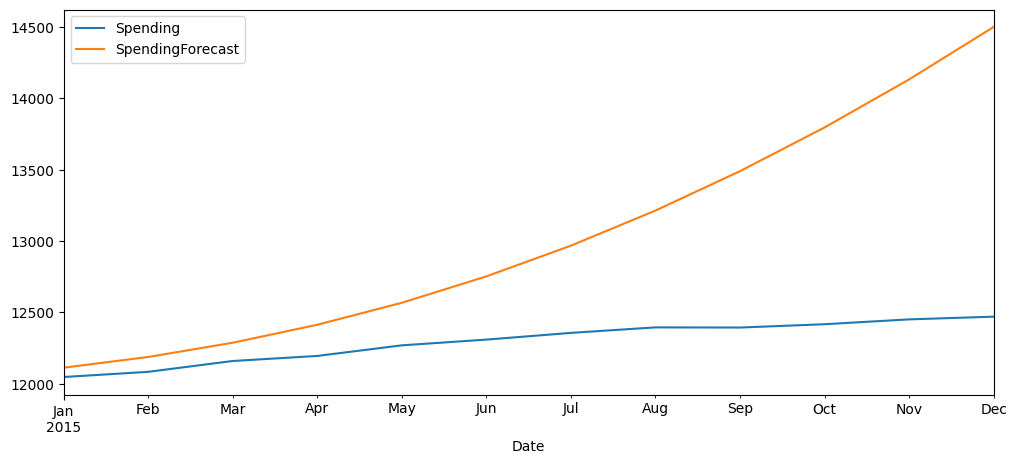

In [176]:
test_original['Spending'].plot(figsize=(12,5),legend=True)
df_forecast['SpendingForecast'].plot(legend=True)